In [7]:
import glob

import numpy as np
from cfgrib.xarray_store import open_dataset
import xarray as xr
import h5py

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


import gcsfs
import load_data 
import importlib
importlib.reload(load_data)
from load_data import load_and_regrid_data, get_lon_lat_reg, get_ai_models, get_cGAN, get_IMERG_year


In [8]:
models = ['graphcast', 'fuxi']

df_all = []

for year in [2021,2022,2023]:
    if year>2022:
        df_all.append(load_and_regrid_data(models, year, era5=False, true_netcdf=False))
    else:
        df_all.append(load_and_regrid_data(models, year, era5=False, true_netcdf=True))

df_ai = xr.concat([df[0] for df in df_all],dim='time',coords='minimal')
df_IMERG = xr.concat([df[1] for df in df_all],dim='time')

100%|███████████████████████████████████████████████████████████████████████| 366/366 [20:20<00:00,  3.34s/it]


(366, 384, 352)
Regridding data for models: ['graphcast', 'fuxi']  at year: 2023 (384,) (352,)


In [9]:
df_IMERG = xr.concat([get_IMERG_year(2018), get_IMERG_year(2019), get_IMERG_year(2020), df_IMERG], dim='time')



In [10]:
df_IMERG

<xarray.Dataset> Size: 1GB
Dimensions:        (lon: 352, lat: 384, time: 2192)
Coordinates:
  * lon            (lon) float32 1kB 19.15 19.25 19.35 ... 54.05 54.15 54.25
  * lat            (lat) float32 2kB -13.65 -13.55 -13.45 ... 24.45 24.55 24.65
  * time           (time) datetime64[ns] 18kB 2018-01-01 ... 2024-01-01
Data variables:
    precipitation  (time, lat, lon) float32 1GB dask.array<chunksize=(1, 322, 322), meta=np.ndarray>
Attributes:
    description:  24h average of IMERG V07 rainfall data in the ICPAC region

In [11]:
import sys
sys.path.insert(1, '/home/n/nath/aimodels_exp/')
import ar_generator 

import importlib
importlib.reload(ar_generator)

ar = ar_generator.model()
ar.fit(df_IMERG.sel({'time':np.arange('2018-01-01','2022-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]')}))



Performing fit for AR(1) coefficients and GPD parameters
Extracted seasonal cycle
Extracted AR(1) coefficients and covariance matrix and all done in ---- 177.46304845809937 s----


In [12]:
predictions = []

for date in np.arange('2023-01-01','2024-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]'):
    predictions.append(ar.predict_xr(50, date, 1))

predictions = xr.concat(predictions, dim='time')


Generated 50 emulations of length 1 in ---- 36.16714906692505 s----
Generated 50 emulations of length 1 in ---- 36.57130527496338 s----
Generated 50 emulations of length 1 in ---- 35.97593927383423 s----
Generated 50 emulations of length 1 in ---- 36.66998910903931 s----
Generated 50 emulations of length 1 in ---- 36.77496099472046 s----
Generated 50 emulations of length 1 in ---- 37.2167387008667 s----
Generated 50 emulations of length 1 in ---- 37.98773503303528 s----
Generated 50 emulations of length 1 in ---- 35.86534833908081 s----
Generated 50 emulations of length 1 in ---- 40.755677223205566 s----
Generated 50 emulations of length 1 in ---- 36.563090085983276 s----
Generated 50 emulations of length 1 in ---- 36.43288445472717 s----
Generated 50 emulations of length 1 in ---- 38.366758823394775 s----
Generated 50 emulations of length 1 in ---- 39.17199373245239 s----
Generated 50 emulations of length 1 in ---- 40.564966917037964 s----
Generated 50 emulations of length 1 in ---- 4


KeyboardInterrupt



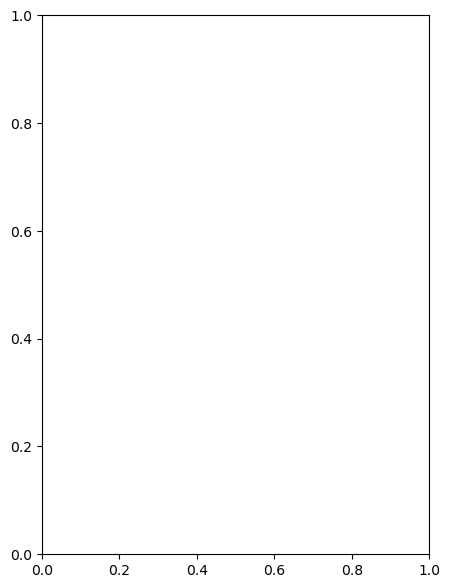

In [79]:

fs_title=16

fig=plt.figure(figsize=(5,7))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


ax = fig.add_subplot(1,1,1)

ax.hist(df_IMERG.sel({'time':np.arange('2020-01-01','2021-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]')}).precipitation.values.flatten(),bins=100, color='k', label='IMERG', density=True)
ax.hist(predictions.precipitation.values.flatten(),bins=100, color='r', alpha=0.7, density=True, label='AR process')

ax.set_xlim(0,4.5)
ax.set_ylim(0,1)

ax.set_xlabel('Rainfall [mm/hr]')
ax.set_ylabel('Count [-]')

plt.title('Rainfall Histogram')

plt.legend()      

In [13]:
predictions

<xarray.Dataset> Size: 20GB
Dimensions:         (lon: 352, lat: 384, time: 365, n_realisations: 50)
Coordinates:
  * lon             (lon) float32 1kB 19.15 19.25 19.35 ... 54.05 54.15 54.25
  * lat             (lat) float32 2kB -13.65 -13.55 -13.45 ... 24.45 24.55 24.65
    month           (time) int64 3kB 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12
  * time            (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
  * n_realisations  (n_realisations) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
Data variables:
    precipitation   (n_realisations, lat, lon, time) float64 20GB dask.array<chunksize=(50, 322, 322, 1), meta=np.ndarray>

In [84]:
predictions['time']=np.arange('2020-01-01','2020-12-31',np.timedelta64(1,'D'),dtype='datetime64[ns]')

In [ ]:
predictions.to_netcdf('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/ar_generated_preds_2020.nc')

In [90]:
from properscoring import crps_ensemble

def crps_xr(observations,forecasts):

    #print(forecasts.shape)

    crps = np.array([crps_ensemble(obs,forecast) for forecast,obs in zip(forecasts,observations)])

    return np.nanmean(crps)


crps = xr.apply_ufunc(crps_xr,
                      df_IMERG.sel({'time':np.arange('2020-01-01','2020-12-31',np.timedelta64(1,'D'),dtype='datetime64[ns]')}).compute(),
                      predictions.drop('month').compute(),
                      input_core_dims = [['time'],['time','n_realisations']],
                      vectorize=True)

KeyboardInterrupt: 

In [ ]:
from properscoring import crps_ensemble

def crps_xr(observations,forecasts):

    #print(forecasts.shape)

    crps = np.array([crps_ensemble(obs,forecast) for forecast,obs in zip(forecasts,observations)])

    return np.nanmean(crps)


crps = xr.apply_ufunc(crps_xr,
                      df_IMERG.sel({'time':np.arange('2020-01-01','2021-01-01',np.timedelta64(1,'D'),dtype='datetime64[ns]')}).compute(),
                      df_cgan.rename({'latitude':'lat','longitude':'lon'}).drop('fcst_valid_time').compute(),
                      input_core_dims = [['time'],['time','member']],
                      vectorize=True)


In [ ]:
import joblib
import cartopy.feature as cfeature
import xarray as xr

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.Robinson())


ax.gridlines()
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)


model = 'fuxi'
mask = xr.open_dataset("/network/group/aopp/predict/TIP022_NATH_GFSAIMOD//cGAN/constants-regICPAC/lsm.nc").lsm.values.astype(bool)

crps_all = np.zeros([mask.shape[0], mask.shape[1]])

crps_temp = joblib.load('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/'+model+'/postprocessing_results/crps_test.pkl')

crps_all[mask] = crps_temp[mask]

crps_temp = joblib.load('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/'+model+'/postprocessing_results/crps_test_land.pkl')

crps_all[~mask] = crps_temp[~mask]

crps_clim = xr.open_dataset('/network/group/aopp/predict/TIP017_COOPER_SURFACE/cGAN/ICPAC/IMERG_scores/CRPS_24h_2020_run2.nc')


crpss = crps_all-crps_clim.IMERG_CRPS.mean('valid_time').values

mesh = ax.pcolormesh(df_IMERG.lon.values, df_IMERG.lat.values, crpss, vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree(), cmap='coolwarm')
cbar = plt.colorbar(mesh)


In [ ]:
import joblib
import cartopy.feature as cfeature
import xarray as xr

fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.Robinson())


ax.gridlines()
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)


model = 'fuxi'
mask = xr.open_dataset("/network/group/aopp/predict/TIP022_NATH_GFSAIMOD//cGAN/constants-regICPAC/lsm.nc").lsm.values.astype(bool)

crps_all = np.zeros([mask.shape[0], mask.shape[1]])

crps_temp = joblib.load('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/'+model+'/postprocessing_results/crps_test.pkl')

crps_all[mask] = crps_temp[mask]

crps_temp = joblib.load('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/'+model+'/postprocessing_results/crps_test_land.pkl')

crps_all[~mask] = crps_temp[~mask]

crps_clim = xr.open_dataset('/network/group/aopp/predict/TIP017_COOPER_SURFACE/cGAN/ICPAC/IMERG_scores/CRPS_24h_2020_run2.nc')


crpss = crps_all-crps_clim.IMERG_CRPS.mean('valid_time').values

mesh = ax.pcolormesh(df_IMERG.lon.values, df_IMERG.lat.values, crpss, vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree(), cmap='coolwarm')
cbar = plt.colorbar(mesh)
